# This notebook shows how compression impacts attributions

### It was inspired by the work in https://arxiv.org/pdf/2010.15054.pdf where they show the same idea in the computer vision

In [1]:
# import torch stuff
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch import optim

# import for dataset and error metric 
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# useful stuff
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import random
def seed_all(seed):
    if not seed:
        seed = 10
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(1)

In [3]:
# the boston housing datset
boston = datasets.load_boston()


X= boston.data
y= boston.target
X = X.astype(np.float32)
y = y.astype(np.float32)
X = MinMaxScaler().fit_transform(X.astype(np.float32))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
X_train.shape

(379, 13)

In [5]:
# Dataset object ...to feed data with arrangment to the network
class Data(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
            
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

In [6]:
# batch size 32
bs=32

train_loader = torch.utils.data.DataLoader(dataset=Data(X_train,y_train), batch_size=bs)
test_loader = torch.utils.data.DataLoader(dataset=Data(X_test,y_test), batch_size=bs,shuffle=False)

In [7]:
#  Define a model 

class Model(torch.nn.Module):
    def __init__(self, n_features):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_features, 50)
        self.layer2= nn.Linear(50, 10)
        self.layer3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## here two models are defined , one the original, the other to be compressed (pruned)

In [8]:
in_features=len(boston.feature_names)

# defining two models, one the orginal, the other to 
Net=Model(in_features)

learning_rate=.01
# define loss function and optimizer...MSE loss as the task is regression task
optim_org = optim.Adam(Net.parameters(), lr=learning_rate)

epoches=100

In [9]:
def train(model,optimizer,epoches,reg=0):
    criterion = nn.MSELoss(size_average=False)
    
    model.train()
    for epoch in range(epoches):
        for inputs, target in train_loader:
            optimizer.zero_grad()
            y_pred = model(inputs)
            
            loss = criterion(y_pred, torch.unsqueeze(target,dim=1))
            
            l2_lambda = 0.001 
            #             hyperparameters for regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

            if reg!=0:
                loss = loss + l2_lambda * l2_norm

            loss.backward()

            optimizer.step()

### Train the two models

In [10]:
train(Net,optim_org,epoches,reg=0)

/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## As a performance measure, use Mean Absolute error

In [11]:
def get_error(model):
    y_pred_new = []
    y_true_new = []
    model.train(False)
    for inputs, labels in test_loader:
        y_pred_new.extend(model(inputs).data.numpy())
        y_true_new.extend(labels.numpy())
    
    return mean_absolute_error(y_true_new, y_pred_new)

In [12]:
import copy

In [13]:
model=copy.deepcopy(Net)
optim_comp= optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
print('Error of the two networks : ', get_error(Net), ' ', get_error(model))

Error of the two networks :  2.5662549   2.5662549


### take the layers of model to be compressed, and assign variables to keep track of the parameters

In [15]:
layers=[i for i in model.modules()][1:]
# total number of weights 
num_of_weights=sum([torch.numel(i.weight.data) for i in layers ])
num_of_biases=sum([torch.numel(i.bias.data) for i in layers ])
total_pars=num_of_biases+ num_of_weights

In [16]:
# list of all the modules, as layers

nonzero_weights= lambda: sum([torch.count_nonzero(i.weight.data) for i in layers ])
nonzero_biases= lambda: sum([torch.count_nonzero(i.bias.data) for i in layers ])
total_non_zero=lambda : (nonzero_weights()+nonzero_biases()).detach().numpy().item()

par_to_prune=[]
for i in layers:
    par_to_prune.append((i,'weight'))
    par_to_prune.append((i,'bias'))
par_to_prune=tuple(par_to_prune)

## current stat of the model

In [17]:
print(
    'Total parameters:' , total_pars,'\n','Total non-zero paramters : ', total_non_zero()
)

Total parameters: 1221 
 Total non-zero paramters :  1221


## Pruning library

####  global pruning as recommended in https://mitibmwatsonailab.mit.edu/research/blog/comparing-rewinding-and-fine-tuning-in-neural-network-pruning/

In [18]:
import torch.nn.utils.prune as prune
prune_global=lambda : prune.global_unstructured(par_to_prune,prune.L1Unstructured,amount=.2 )

In [19]:
def rewind():
    """Rewind model params"""
    for i in layers:
        i.weight=i.weight*i.weight_mask
        i.bias=i.bias*i.bias_mask

### Keep track of these things

In [20]:
#  A list to keep the accuracy over time
acc_over_time=[get_error(model)]

#  A list to keep the accuracy over time
zeros_over_time=[total_pars-total_non_zero()]

# A list of the non zeros over time
non_zero_over_time=[total_non_zero()]

In [21]:
# Keep an eye on the baseline error
baseline=get_error(Net)

# how much accuracy are you willing to sacrify ? here I set it to .1 unit error
BEAR = .2

# Parameter percentage is the weight percentage you want the network to loss
P=.85

In [22]:
baseline

2.5662549

### The next cell is the compressing loop, (pruning, train, and then rewind )

#### It trains with regularization

In [23]:
first=True
# error=0
while True:
    if first:
        prune_global()    
        first=False
    elif error<=BEAR:  
        prune_global()
        
    train (model,optim_comp,epoches, reg=1)
    rewind()
    
    
    acc_over_time.append(round(get_error(model),1))   
    non_zero_over_time.append(total_non_zero())

    zeros_over_time.append(total_pars-non_zero_over_time[-1])
    error=abs(acc_over_time[-1]- baseline)
    print('Non zero: ',non_zero_over_time[-1], ', performance ',acc_over_time[-1],', error : ',error )
    
    
    if zeros_over_time[-1]>P*total_pars and error<=BEAR:
        print('Weght percentage : ', 100*non_zero_over_time[-1]/total_pars, ' %')
        break    

/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.0 , error :  0.56625485


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.0 , error :  0.56625485


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.1 , error :  0.46625495


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.0 , error :  0.56625485


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.1 , error :  0.46625495


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.1 , error :  0.46625495


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.1 , error :  0.46625495


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.2 , error :  0.3662548


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  977 , performance  2.4 , error :  0.16625476


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  782 , performance  2.4 , error :  0.16625476


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  626 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  626 , performance  2.5 , error :  0.066254854


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  501 , performance  2.6 , error :  0.03374505


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  401 , performance  2.4 , error :  0.16625476


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  321 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  321 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  321 , performance  2.3 , error :  0.2662549


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  321 , performance  2.4 , error :  0.16625476


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  257 , performance  2.4 , error :  0.16625476


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  206 , performance  2.5 , error :  0.066254854


/home/person/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Non zero:  165 , performance  2.7 , error :  0.1337452
Weght percentage :  13.513513513513514  %


## The compression is over, 85% of the params are now 0

In [30]:
print(
    'Total parameters:' , total_pars,'\n','Total non-zero paramters : ', total_non_zero(),
    
    '\n', 'Error of the compressed model ', get_error(model),
    '\n', 'Error of the original model ', get_error(Net)
    
)

Total parameters: 1221 
 Total non-zero paramters :  165 
 Error of the compressed model  2.6673882 
 Error of the original model  2.5662549


## Now the task is to get explainanations for each
### I use shap, a unified apporach for model attribution https://arxiv.org/abs/1705.07874

In [35]:
# import shap library
import shap

In [32]:
# for original model Net
explainer = shap.DeepExplainer(Net,torch.tensor(train_loader.dataset.x))
shap_values = explainer.shap_values(torch.tensor(test_loader.dataset.x))

# for compressed model
explainer_compressed = shap.DeepExplainer(model,torch.tensor(train_loader.dataset.x))
shap_values_compressed = explainer_compressed.shap_values(torch.tensor(test_loader.dataset.x))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


### Plot the attributions of the original model

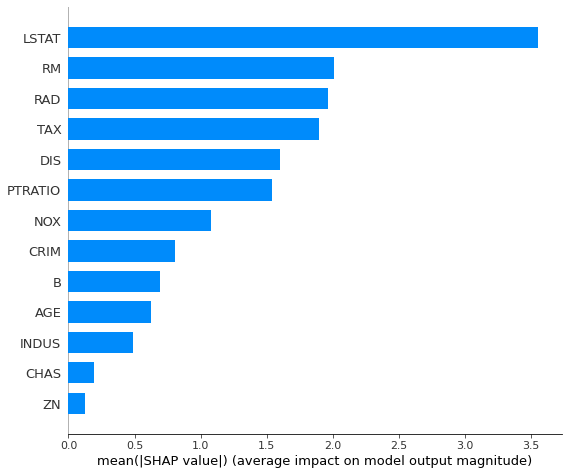

In [33]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = list(boston.feature_names))

### Plot the attributions of the original model

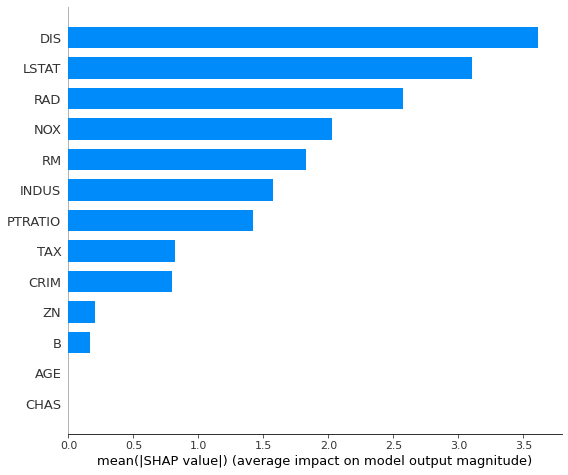

In [36]:
shap.summary_plot(shap_values_compressed, plot_type = 'bar', feature_names = list(boston.feature_names))

### Results

As it can clearly be seen, there is a differnece between the two attribution maps.
For example, the most prominent feature in the original model was 'LSTAT' but in the second one it is "DIS'
There are other differnces as well.

This concludes the note book